In [2]:
%pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 4.2/4.2 MB 50.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
import importlib
import model 
importlib.reload(model)


<module 'model' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\wavelet-transform\\model.py'>

In [27]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from model import SwtForecastingModel, swt_decompose, swt_reconstruct, EarlyStopping
import argparse
import matplotlib.pyplot as plt
import os


In [23]:
# --- DEVICE SETUP ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {DEVICE}")

# --- DECOMPOSITION ---
def decompose_batch(batch, level=2):
    required_multiple = 2 ** level
    bands = [[] for _ in range(4)]
    for seq in batch:
        seq = np.asarray(seq).flatten()
        valid_len = (len(seq) // required_multiple) * required_multiple
        if valid_len % 2 != 0:
            valid_len -= 1
        seq = seq[:valid_len]
        coeffs = swt_decompose(seq, level=level)
        a2, d2 = coeffs[0]
        d1 = coeffs[1][1]
        zero_pad = np.zeros_like(d1)
        for i, band in enumerate([a2, d2, d1, zero_pad]):
            bands[i].append(band)
    return [torch.tensor(np.array(b), dtype=torch.float32).unsqueeze(-1).to(DEVICE) for b in bands]

def decompose_targets(batch, level=2):
    bands = [[] for _ in range(4)]
    for seq in batch:
        seq = np.asarray(seq).flatten()
        valid_len = (len(seq) // (2 ** level)) * (2 ** level)
        seq = seq[:valid_len]
        coeffs = swt_decompose(seq, level=level)
        a2, d2 = coeffs[0]
        d1 = coeffs[1][1]
        zero_pad = np.zeros_like(d1)
        for i, band in enumerate([a2, d2, d1, zero_pad]):
            bands[i].append(band)
    return [torch.tensor(np.array(b), dtype=torch.float32).unsqueeze(-1).to(DEVICE) for b in bands]

# --- CONFIG ---
args = {
    "t": 0.2,
    "s": 24,
    "w": 48,
    "level": 3
}

# --- DATA LOADING ---
df = pd.read_csv("mm79158.csv", parse_dates=['ts'])
df.set_index('ts', inplace=True)
data = df['vrednost'].values.reshape(-1, 1)

X_raw, y_raw = [], []
for i in range(len(data) - args['w'] - args['s'] + 1):
    X_raw.append(data[i:i + args['w']])
    y_raw.append(data[i + args['w']:i + args['w'] + args['s']])

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)

# --- SPLIT ---
test_size = int(len(X_raw) * args['t'])
val_size = test_size
train_size = len(X_raw) - test_size - val_size

X_train, y_train = X_raw[:train_size], y_raw[:train_size]
X_val, y_val = X_raw[train_size:train_size + val_size], y_raw[train_size:train_size + val_size]
X_test, y_test = X_raw[train_size + val_size:], y_raw[train_size + val_size:]

# --- SCALE ---
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# --- DECOMPOSE ---
X_train_tensors = decompose_batch(X_train, level=args['level'])
X_val_tensors = decompose_batch(X_val, level=args['level'])
X_test_tensors = decompose_batch(X_test, level=args['level'])

y_train_tensors = decompose_targets(y_train, level=args['level'])
y_val_tensors = decompose_targets(y_val, level=args['level'])

# --- DATASET ---
train_dataset = TensorDataset(*X_train_tensors, *y_train_tensors)
val_dataset = TensorDataset(*X_val_tensors, *y_val_tensors)

test_dataset = TensorDataset(*X_test_tensors, torch.tensor(y_test, dtype=torch.float32).to(DEVICE))

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# --- MODEL ---
model = SwtForecastingModel(
    input_size=1,
    time2vec_k=8,
    d_model=480,
    n_heads=12,
    d_ff=128,
    n_enc_layers=2,
    n_dec_layers=1,
    forecast_steps=args['s'],
    output_bands=len(X_train_tensors)
).to(DEVICE)


🚀 Using device: cuda


In [29]:
model = SwtForecastingModel(
    input_size=1,
    time2vec_k=8,
    d_model=480,
    n_heads=12,
    d_ff=128,
    n_enc_layers=2,
    n_dec_layers=1,
    forecast_steps=args['s'],
    output_bands=len(X_train_tensors)  # e.g., 4 for [(A2, D2), (A1, D1)]
).to(DEVICE)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

for epoch in range(30):
    model.train()
    train_loss = 0
    num_batches = len(train_loader)
    print(f"\nEpoch {epoch+1:02d}/{30}")

    for batch_idx, batch in enumerate(train_loader):
        num_bands = len(batch) // 2
        x_band_tensor = [x.to(DEVICE) for x in batch[:num_bands]]
        y_band_tensor = [y.to(DEVICE) for y in batch[num_bands:]]

        x_stack = torch.stack(x_band_tensor, dim=1)  # [B, bands, W, 1]
        y_stack = torch.stack(y_band_tensor, dim=1)  # [B, bands, s, 1]

        preds = model(x_stack)  # [B, bands, s, 1]
        loss = loss_fn(preds, y_stack)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * y_stack.size(0)

        # Print mini-batch progress
        print(f"\r - Batch {batch_idx+1}/{num_batches} - loss: {loss.item():.6f}", end="")

    train_loss /= len(train_loader.dataset)

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            num_bands = len(batch) // 2
            x_band_tensor = [x.to(DEVICE) for x in batch[:num_bands]]
            y_band_tensor = [y.to(DEVICE) for y in batch[num_bands:]]

            x_stack = torch.stack(x_band_tensor, dim=1)  # [B, bands, W, 1]
            y_stack = torch.stack(y_band_tensor, dim=1)  # [B, bands, s, 1]

            preds = model(x_stack)
            loss = loss_fn(preds, y_stack)
            val_loss += loss.item() * y_stack.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"\n[Epoch {epoch+1:02d}] Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}")

    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered.")
        model.load_state_dict(early_stopper.best_state_dict)
        break


Epoch 01/30
 - Batch 284/284 - loss: 3.468350
[Epoch 01] Train loss: 4.179733 | Val loss: 4.885832

Epoch 02/30
 - Batch 284/284 - loss: 3.596560
[Epoch 02] Train loss: 3.669994 | Val loss: 4.904720

Epoch 03/30
 - Batch 284/284 - loss: 3.438471
[Epoch 03] Train loss: 3.668981 | Val loss: 4.928848

Epoch 04/30
 - Batch 267/284 - loss: 4.194942

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
model = SwtForecastingModel(...)  # same architecture
model.load_state_dict(torch.load("model_weights.pth"))
model.to(DEVICE)
model.eval()


📊 Final Flattened Evaluation:
MAE:  3.9053
MSE:  25.9139
MAPE: 398.80%


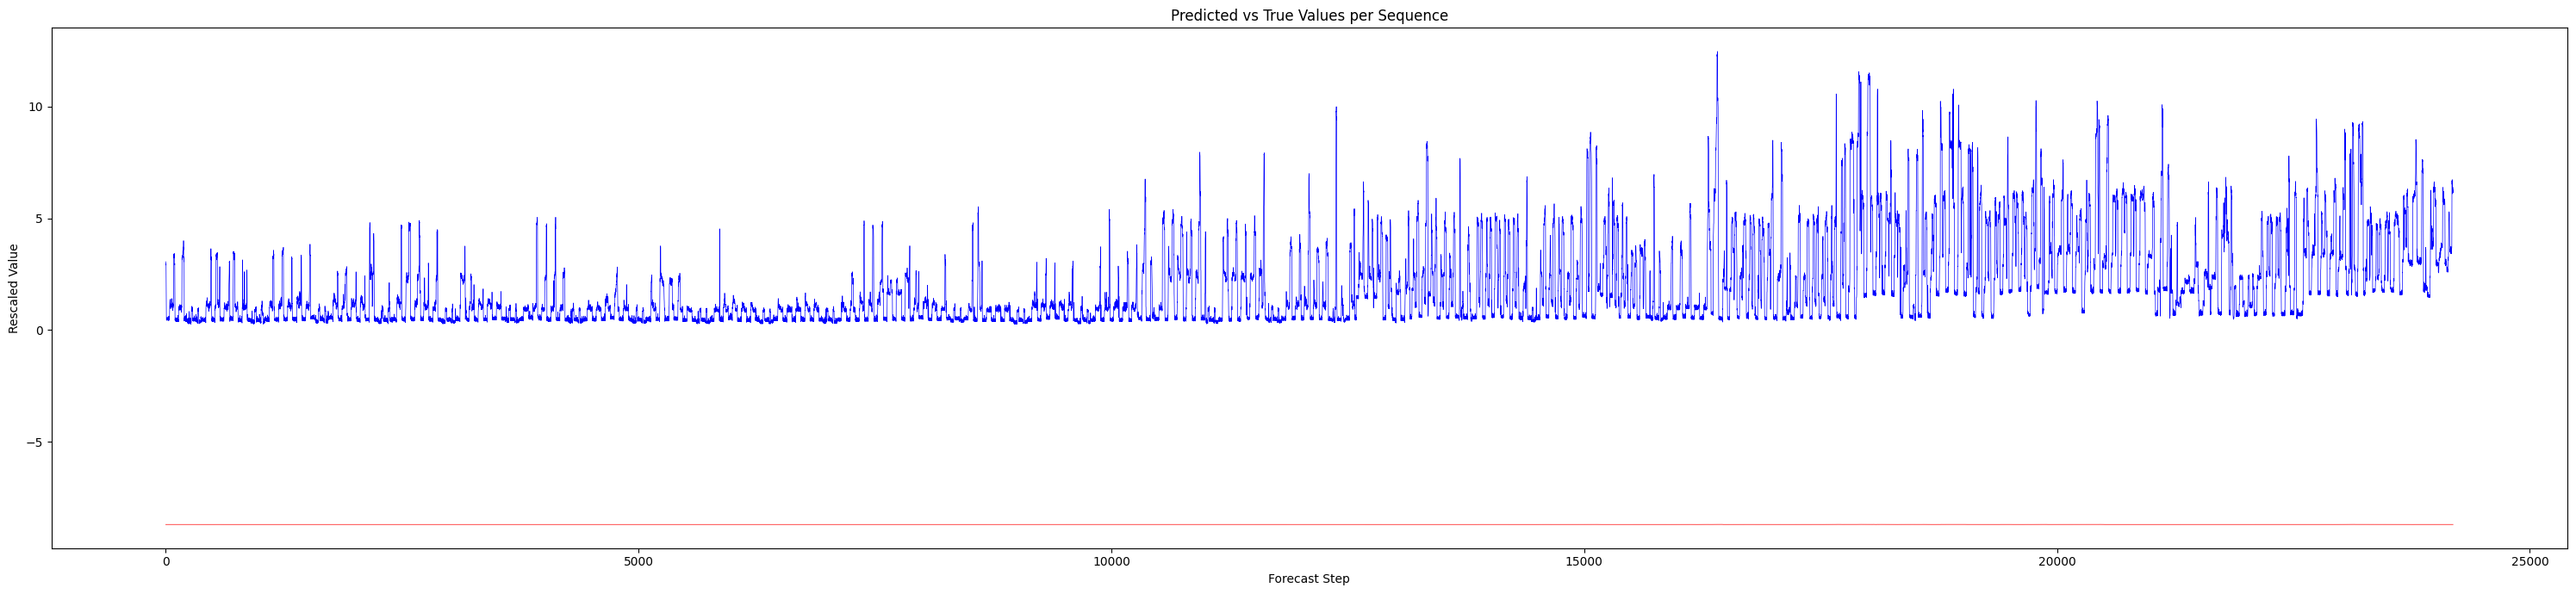

In [ ]:
model.eval()
preds = []
y_true = []

with torch.no_grad():
    for *x_bands, y_batch in test_loader:
        # === Predict and squeeze to [B, bands, s]
        out = model(x_bands).squeeze(-1)  # [B, bands, s]
        B, bands, s = out.shape

        for b in range(B):
            # Prepare coefficients for swt_reconstruct
            band_preds = out[b].detach().cpu().numpy()  # [bands, s]

            # Assume SWT level = 2, so we reverse engineer coeffs
            # Format: [(a2, d2), (a1, d1), ...]
            coeffs = []
            if bands >= 3:
                # Build from predicted subbands
                a2 = band_preds[0]
                d2 = band_preds[1]
                d1 = band_preds[2]
                a1 = np.zeros_like(d1)
                coeffs = [(a2, d2), (a1, d1)]
            else:
                raise ValueError("At least 3 bands are needed for reconstruction.")

            # Optional: add more levels if you're using level > 2

            # === Reconstruct signal
            recon = swt_reconstruct(coeffs)  # full reconstructed sequence
            recon_tensor = torch.tensor(recon[-args['s']:], dtype=torch.float32)  # last `s` steps

            # === Inverse scale
            recon_unscaled = scaler.inverse_transform(recon_tensor.view(-1, 1)).flatten()
            preds.append(torch.tensor(recon_unscaled, dtype=torch.float32))

            # === Unscale ground truth
            y_true_cpu = y_batch[b].detach().cpu().view(-1, 1).numpy()
            y_true.append(torch.tensor(y_true_cpu, dtype=torch.float32))

# === Stack & Evaluate
preds = torch.stack(preds)  # [B, s]
y_true = torch.stack(y_true)  # [B, s]

preds_flat = preds.reshape(-1).numpy()
y_true_flat = y_true.reshape(-1).numpy()

mae = mean_absolute_error(y_true_flat, preds_flat)
mse = mean_squared_error(y_true_flat, preds_flat)
mape = mean_absolute_percentage_error(y_true_flat, preds_flat)

print("\n📊 Final Flattened Evaluation:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"MAPE: {mape:.2%}")

# === Plot first time step of each sequence
y_true_unrolled = y_true[:, 0]
pred_unrolled = preds[:, 0]

plt.figure(figsize=(30, 7))
plt.plot(y_true_unrolled, color='blue', linewidth=0.5, label='True Values')
plt.plot(pred_unrolled, color='red', linewidth=0.5, label='Predicted Values')
plt.title("Predicted vs True Values per Sequence")
plt.xlabel("Forecast Step")
plt.ylabel("Rescaled Value")
plt.legend()
plt.tight_layout()
plt.show()
